# Preamble

Import necessary packages and setup logging.

In [1]:
from dolfin import *
import numpy as np

import sys
sys.path.append( "./hippylib" )
from hippylib import *

import logging

import matplotlib.pyplot as plt
sys.path.append( "./hippylib/tutorial" )
import nb

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)

from collections import deque

# Setup Function Spaces


In [2]:
# TODO: Pick the spaces carefully
nx = 64
ny = 64
mesh = UnitSquareMesh(nx, ny)
Vs = FunctionSpace(mesh, 'Lagrange', 2)
Vu = FunctionSpace(mesh, 'Lagrange', 2)


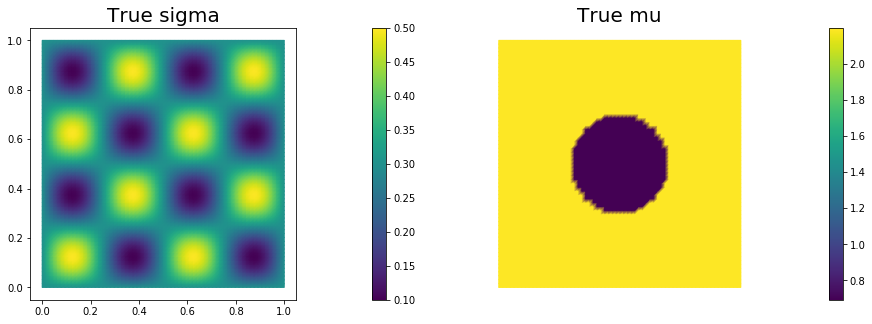

In [3]:
# TODO: Initialize these to the right values
# The true and inverted parameter
sigma_true = interpolate(Expression('0.3 + 0.2 * sin(4 * pi * x[0]) * sin(4 * pi * x[1])', degree=5),Vs)
sigma = interpolate(Expression('0.3 + 0.2 * sin(4 * pi * x[0]) * sin(4 * pi * x[1])', degree=2),Vs)

mu_true = interpolate(Expression('log(2 + 7*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2),0.5) > 0.2))', degree=5),Vs)
mu = interpolate(Expression('log(2 + 7*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2),0.5) > 0.2))', degree=2),Vs)

plt.figure(figsize=(15,5))
nb.plot(sigma_true, subplot_loc=121, mytitle="True sigma", show_axis='on')
nb.plot(mu_true, subplot_loc=122, mytitle="True mu")
plt.show()

In [4]:
# define function for state and adjoint
u = Function(Vu)
v = Function(Vu)

# define Trial and Test Functions
u_trial, v_trial, sigma_trial, mu_trial = TrialFunction(Vu), TrialFunction(Vu), TrialFunction(Vs), TrialFunction(Vs)
u_test, v_test, sigma_test, mu_test = TestFunction(Vu), TestFunction(Vu), TestFunction(Vs), TestFunction(Vs)

# Gruneisen coefficient
Gamma = Constant("1.0")

# diffusion coefficient
gamma = interpolate(Expression('0.03 + 0.01 * sin(x[1])', degree=3), Vs)

# true solution
u_true = Function(Vu)

kappa = 0.04

## Set up boundary conditions
The semilinear equation has given boundary values whereas the linear equation has homogeneous boundary conditions.

In [5]:
# TODO: bc with g defined by problem
# set up dirichlet boundary conditions
def boundary(x,on_boundary):
    return on_boundary

g = Constant("1.0")
bc_state = DirichletBC(Vu, g, boundary)
bc_adj = DirichletBC(Vu, Constant(0.), boundary)


## Setting up synthetic observations

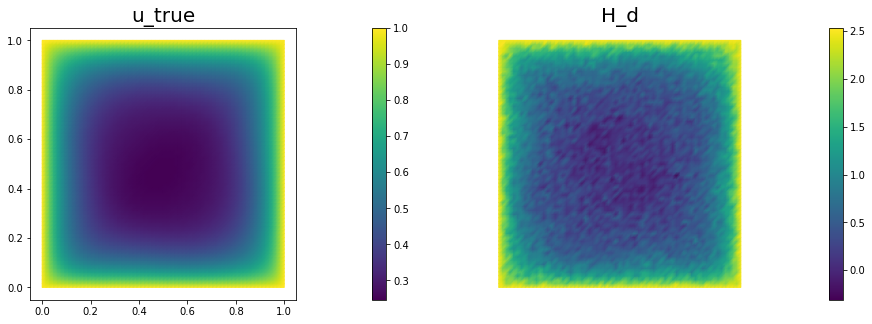

In [6]:
# Set the level of noise:
noise_level = 0.05

F_true = inner(gamma * nabla_grad(u_true), nabla_grad(u_test)) * dx + \
        sigma_true * u_true * u_test * dx + \
        mu_true * abs(u_true) * u_true * u_test * dx

solve(F_true == 0, u_true, bcs = bc_state, solver_parameters={"newton_solver":{"relative_tolerance":1e-6}})
# TODO: Proper noise addition as per paper
H_data = project(Gamma * sigma_true * u_true + Gamma * mu_true * u_true * abs(u_true), Vu)
MAX = H_data.vector().norm("linf")
noise = u_true.vector().copy()
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(H_data.vector().array())) )
bc_adj.apply(noise)
H_data.vector().axpy(1., noise)

plt.figure(figsize=(15,5))
nb.plot(u_true, subplot_loc=121, mytitle="u_true", show_axis='on')
nb.plot(H_data, subplot_loc=122, mytitle="H_d")
plt.show()

## Setting up the objective functional

In [7]:
def mismatch_cost(Gamma, sigma, mu, u, H):
    mismatch = Gamma * sigma * u + Gamma * mu * abs(u) * u - H
    return 0.5 * assemble(inner(mismatch, mismatch) * dx)

def regularization_cost(k, sigma, mu):
    reg_sigma = assemble(inner(grad(sigma),grad(sigma)) * dx)
    reg_mu = assemble(inner(grad(mu),grad(mu)) * dx) 
    return kappa * 0.5 * reg_sigma

def cost(Gamma, sigma, mu, u, H_data, k):
    return mismatch_cost(Gamma, sigma, mu, u, H_data) + regularization_cost(kappa, sigma, mu)

print (cost(Gamma, sigma, mu, u, H_data, k))

0.6283186853260654


## BFGS 

1
0.018874571032490354


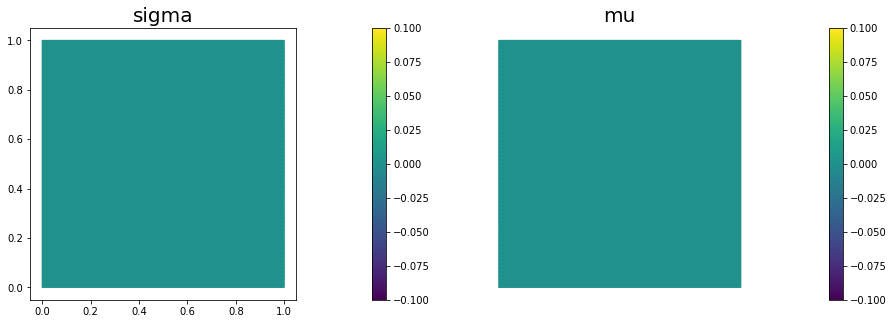

2
1.9378038993311768


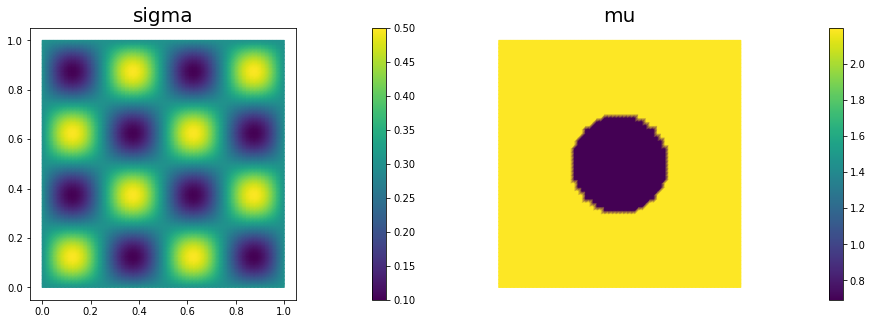

3
0.018874571031852784


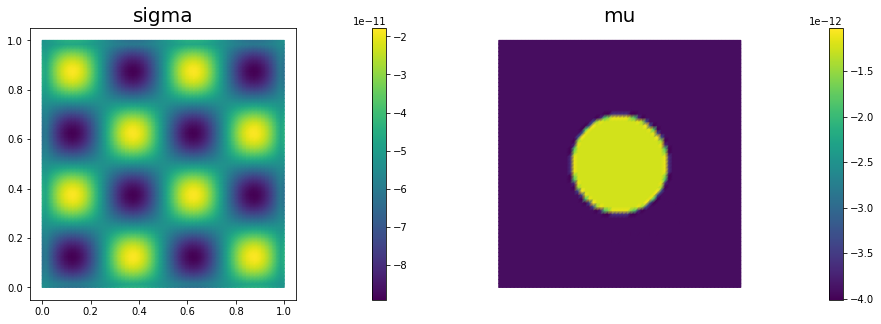

4
1.9378039138165162


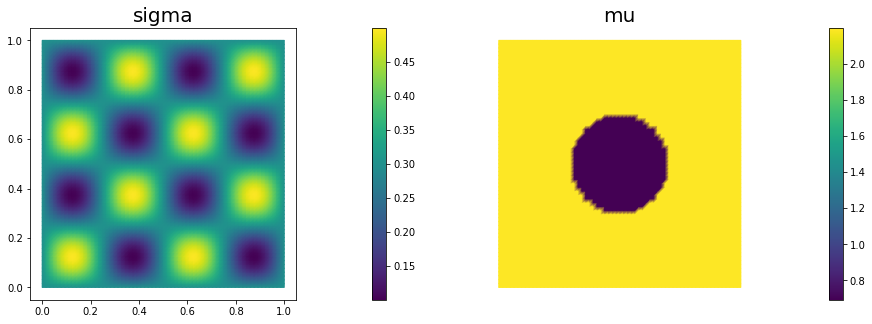

5
0.018874743494851368


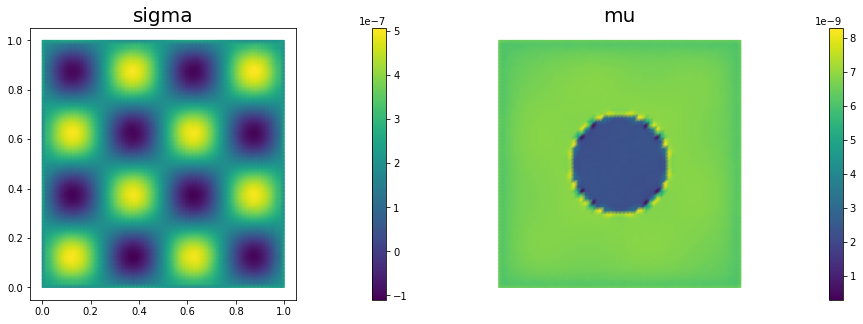

6
1.9372999050104343


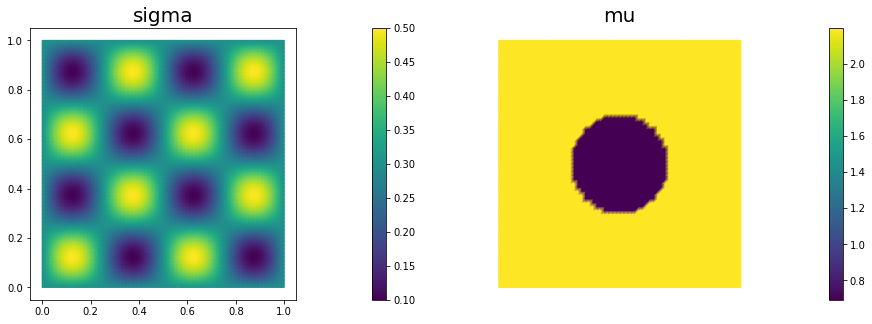

7
0.3208724492617178


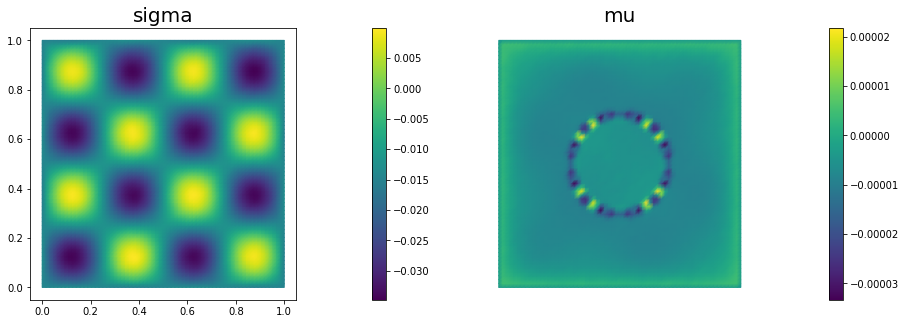

8
7.872812947415328


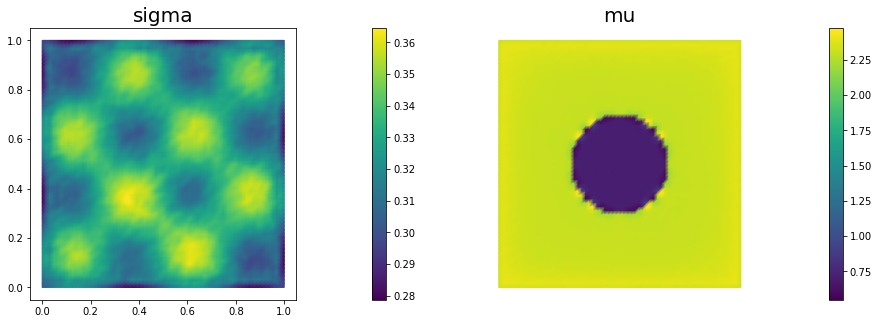

9
393.40215977050065


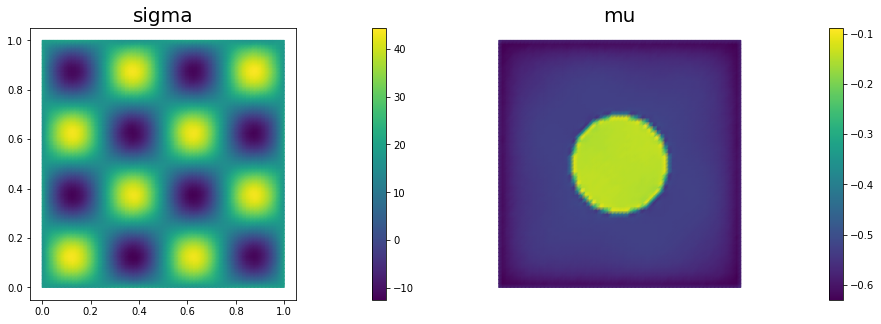

10


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2017.1.0
*** Git changeset:  
*** -------------------------------------------------------------------------


In [8]:
def gradient(gamma, sigma, mu, Gamma, u, v):
    '''
    Computes the gradient of the objective function with respect
    to sigma and mu
    '''

    # semilinear forward equation to obtain u
    forward_eq = inner(gamma * nabla_grad(u), nabla_grad(u_test)) * dx + \
        sigma * u * u_test * dx + \
        mu * abs(u) * u * u_test * dx

    solve(forward_eq == 0, u, bcs = bc_state)

    z = Gamma * (sigma * u + mu * abs(u) * u) - H_data

    # linear adjoint equation to obtain v
    adjoint_eq_bilinear = inner(gamma * nabla_grad(v_trial), nabla_grad(v_test)) * dx + \
        (sigma + 2 * mu * abs(u)) * v_trial * v_test * dx

    adjoint_eq_L = -z * Gamma * sigma * v_test * dx + 2 * mu * abs(u) * v_test * dx

    solve(adjoint_eq_bilinear == adjoint_eq_L, v, bc_adj)

    # use u and v obtain gradients of the objective function w.r.t. sigma and mu
    obj_d_sigma = z * Gamma * u * sigma_test * dx + v * u * sigma_test * dx  - \
        inner(kappa * nabla_grad(sigma), nabla_grad(sigma_test)) * dx

    obj_d_mu = z * Gamma * abs(u) * u * mu_test *  dx + v * abs(u) * u * mu_test * dx - \
        inner(kappa * nabla_grad(mu), nabla_grad(mu_test)) * dx
        
    return assemble(obj_d_sigma), assemble(obj_d_mu)


def L_BFGS(sigma, mu):
    '''
    Limited memory BFGS quasi-Newton method implementation used to 
    solve the minimization problem arising from the least squares reconstruction method.
    For more information about the limited-memory BFGS method, refer to 
    Numerical Optimization by Nocedal and Wright
    '''
    k = 0
    m_MAX = 7
    m = 1
    s_sigma = deque()
    s_mu = deque()
    y_sigma = deque()
    y_mu = deque()
    rho_sigma = deque()
    rho_mu = deque()
    alpha_sigma = [0] * m_MAX
    alpha_mu = [0] * m_MAX
    converged = False
    
    q_sigma, q_mu = gradient(gamma, sigma, mu, Gamma, u, v)
    s_sigma.append(sigma.vector())
    s_mu.append(mu.vector())
    y_sigma.append(q_sigma)
    y_mu.append(q_mu)
    rho_sigma.append(1.0/y_sigma[-1].inner(s_sigma[-1]))
    rho_mu.append(1.0/y_mu[-1].inner(s_mu[-1]))


    while not converged:
        # TODO: Conditions for convergence

        for i in range(0,m):
            alpha_sigma[i] = rho_sigma[i] *  s_sigma[i].inner(q_sigma)
            q_sigma = q_sigma - alpha_sigma[i] * y_sigma[i]
            alpha_mu[i] = rho_mu[i] *  s_mu[i].inner(q_mu)
            q_mu = q_mu - alpha_mu[i] * y_mu[i]
                
        gamma_k_sigma = s_sigma[-1].inner(y_sigma[-1])/y_sigma[-1].inner(y_sigma[-1])
        r_sigma = gamma_k_sigma * q_sigma
    
        gamma_k_mu = s_mu[-1].inner(y_mu[-1])/y_mu[-1].inner(y_mu[-1])
        r_mu = gamma_k_mu * q_mu

        for i in range(m-1,-1,-1):
            # Iterate backwards
            beta_sigma = rho_sigma[i] * y_sigma[i].inner(r_sigma)
            r_sigma = r_sigma + s_sigma[i]*(alpha_sigma[i] - beta_sigma)  
            beta_mu = rho_mu[i] * y_mu[i].inner(r_mu)
            r_mu = r_mu + s_mu[i]*(alpha_mu[i] - beta_mu)  

        p_sigma_k = -r_sigma
        p_mu_k = -r_mu

        # TODO: Satisfy Wolfe conditions for a
        a_sigma = 1
        a_mu = 1

        sigma.vector()[:] = sigma.vector()[:] + a_sigma * p_sigma_k
        mu.vector()[:] = mu.vector()[:] + a_mu * p_mu_k

        k += 1
        print (k)
        if m < m_MAX:
            m += 1

        s_sigma.append(a_sigma * p_sigma_k)
        s_mu.append(a_mu * p_mu_k)

        q_sigma_prev = q_sigma
        q_mu_prev = q_mu
        q_sigma, q_mu = gradient(gamma, sigma, mu, Gamma, u, v)

        y_sigma.append(q_sigma - q_sigma_prev)
        y_mu.append(q_mu - q_mu_prev)

        rho_sigma.append(1.0/y_sigma[-1].inner(s_sigma[-1]))
        rho_mu.append(1.0/y_mu[-1].inner(s_mu[-1]))

        if k >= m_MAX:
            s_sigma.popleft()
            s_mu.popleft()
            y_sigma.popleft()
            y_mu.popleft()
            rho_sigma.popleft()
            rho_mu.popleft()

        grad_norm = norm(q_sigma) + norm(q_mu)
        print (grad_norm)
        plt.figure(figsize=(15,5))
        nb.plot(sigma, subplot_loc=121, mytitle="sigma", show_axis='on')
        nb.plot(mu, subplot_loc=122, mytitle="mu")
        plt.show()

        if grad_norm < 1e-2 or k == 20:
            converged = True
            

L_BFGS(sigma, mu)